In [39]:
plt.rcParams["text.usetex"] = True

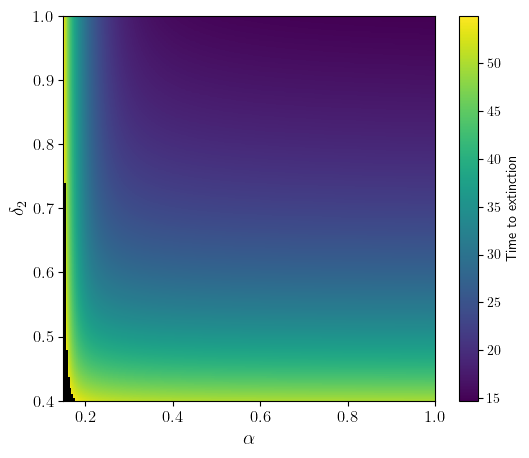

In [42]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Fixed parameters with ONE FIXED INITIAL CONDITION
rho1, rho2 = 0.3, 0.125
CC, A = 0.887, 3.0
x0 = np.array([0.7, 0.3])
T_max = 55.0
thresh = 1e-4

def ode_x(t, x, rho1, rho2, alpha1, delta2, CC, A):
    BA = x.sum()
    dx1 = rho1*x[0]*(1-BA/CC) - alpha1*A*x[0]
    dx2 = rho2*x[1]*(1-BA/CC) + alpha1*A*x[0] - delta2*(A/(1+A))*x[1]
    return [dx1, dx2]

# extinction‐time function
def extinction_time(alpha1, delta2):
    sol = solve_ivp(
        ode_x, [0, T_max], x0,
        t_eval=np.linspace(0, T_max, 2000),
        args=(rho1, rho2, alpha1, delta2, CC, A),
        rtol=1e-8, atol=1e-10
    )
    Btot = sol.y[0] + sol.y[1]
    idx = np.where(Btot < thresh)[0]
    return sol.t[idx[0]] if idx.size else T_max

# build grid
alpha_vals = np.linspace(0.15, 1, 200)
delta_vals = np.linspace(0.4, 1, 200)
Tmat = np.zeros((alpha_vals.size, delta_vals.size))

# fill
for i, α in enumerate(alpha_vals):
    for j, δ in enumerate(delta_vals):
        Tmat[i,j] = extinction_time(α, δ)

# mask non‐extinct points
mask = (Tmat == T_max)
Tmat_masked = ma.masked_where(mask, Tmat)

# prepare colormap so that masked cells appear black
cmap = plt.cm.viridis.copy()
cmap.set_bad('black')

# plot heatmap
plt.figure(figsize=(6,5))
im = plt.imshow(
    Tmat_masked.T,
    origin='lower',
    extent=(alpha_vals[0], alpha_vals[-1],
            delta_vals[0], delta_vals[-1]),
    aspect='auto',
    cmap=cmap
)
cbar = plt.colorbar(im)
cbar.set_label('Time to extinction', fontsize=10)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$\delta_2$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('extinction.pdf')
plt.show()

